In [3]:
import numpy as np
import glob
import random
from scipy import sparse

from tools.text_process import TfidfEncoder
from tools.image_process import getLayerNames, CategEncoder
from tools.joint_process import SimiEncoder

# random image generator, subject to rules
from tools.generator import ranGenLayer

class Dataset():
    def __init__(self, img_dir='images', txt_dir='text'):
        self.img_dir = img_dir
        self.txt_dir = txt_dir
        
        # fitting the vectorizer will process all the text
        # so we have double processed the text here
        self.img_encoder = CategEncoder()
        self.txt_encoder = TfidfEncoder()
        self.joint_encoder = SimiEncoder(self.img_encoder,
                                         self.txt_encoder)
        
        # set features
        self.features_ = []
        self.features_.extend(self.txt_encoder.vocab_)
        self.features_.extend(self.img_encoder.features_)
        self.features_.extend(self.joint_encoder.features_)
      
    def getOneLayerSent(self, txt_name=None, img_name=None,
                              ran_txt=False, ran_img=False,
                              fake_img=False):
        ##### preprocess
        ## text
        if ran_txt:
            all_txt = glob.glob(self.txt_dir+'/*.txt')
            # rule out current text
            all_txt.remove(txt_name)
            txt_name = random.choice(all_txt)
        else:
            assert(txt_name)
            
        with open(txt_name, 'r') as f:
            sent = f.read()
            
        ## image
        if ran_img:
            assert img_name
            assert not fake_img
            all_img = glob.glob(self.img_dir+'/*.svg')
            all_img.remove(img_name)
            img_name = random.choice(all_img)
            layers = getLayerNames(img_name)
        elif fake_img:
            assert img_name is None
            assert not ran_img
            layers = ranGenLayer()
        else:
            layers = getLayerNames(img_name)
            
        return layers, sent
        
    def __getEmbed(self, **kwargs):
        
        layers, sent = self.getOneLayerSent(**kwargs)
        
        # tofeature
        txt_embed = self.txt_encoder.encode(sent)
        img_embed = self.img_encoder.encode(layers)
        joint_embed = self.joint_encoder.encode(layers, sent)
        
        return np.hstack([txt_embed, img_embed, joint_embed])        
    
    def __getitem__(self, ind):
        img_name = '%s/%i.svg' % (self.img_dir, ind+1)
        txt_name = '%s/%i.txt' % (self.txt_dir, ind+1)
        
        # triplets
        triplets = []
        # true match
        triplets.append(self.__getEmbed(txt_name=txt_name,
                                        img_name=img_name))
        # fake image
        triplets.append(self.__getEmbed(txt_name=txt_name,
                                        fake_img=True))
        # mismatched text
        triplets.append(self.__getEmbed(img_name=img_name,
                                        txt_name=txt_name,
                                        ran_txt=True))
        # mismatched image
        triplets.append(self.__getEmbed(img_name=img_name,
                                        txt_name=txt_name,
                                        ran_img=True))
        
        xs = np.vstack(triplets)
        
        # ys
        ys = np.array([1,0,0,0]).reshape(-1,1)
        
        return sparse.csr_matrix(np.hstack([xs, ys]))

    
    def __len__(self):
        return len(glob.glob(self.img_dir+'/*.svg'))


In [4]:
dataset = Dataset()
print('# features: ', len(dataset.features_))
data = sparse.vstack([dataset[i] for i in range(len(dataset))])
X, y = data[:,:-1], data[:,-1]
y = y.toarray().flatten()
print('data shape', data.shape)

# features:  6398


/Users/dongjustin/Documents/Text2Scene/Text2Scene/tools/text_process.py:48: UserWarning: cell with tag r does not belong to any synsets.
  warnings.warn('%s with tag %s does not belong to any synsets.' % (lemma, tag))
/Users/dongjustin/Documents/Text2Scene/Text2Scene/tools/text_process.py:48: UserWarning: something with tag n does not belong to any synsets.
  warnings.warn('%s with tag %s does not belong to any synsets.' % (lemma, tag))
/Users/dongjustin/Documents/Text2Scene/Text2Scene/tools/text_process.py:48: UserWarning: sideways with tag n does not belong to any synsets.
  warnings.warn('%s with tag %s does not belong to any synsets.' % (lemma, tag))
/Users/dongjustin/Documents/Text2Scene/Text2Scene/tools/text_process.py:48: UserWarning: grid with tag a does not belong to any synsets.
  warnings.warn('%s with tag %s does not belong to any synsets.' % (lemma, tag))


data shape (168, 6399)


In [14]:
layers, sentence = dataset.getOneLayerSent(txt_name='text/1.txt',
                                       img_name='images/6.svg')
print(layers)
print(dataset.img_encoder.layer2keyword(layers))
print(sentence)
list(filter(lambda x: x[1]!=0, zip(dataset.joint_encoder.features_, dataset.joint_encoder.encode(layers, sentence))))

['A2112', 'A311']
['indoor.a.01', 'object.n.01', 'appliance.n.02', 'interaction.n.01', 'occupation.n.01']
A man looks at his chart with his back.



[('_S_object.n.01_back.n.01_', 1.845826690498331),
 ('_S_object.n.01_chart.n.01_', 1.6916760106710724),
 ('_S_object.n.01_man.n.01_', 1.845826690498331),
 ('_S_appliance.n.02_back.n.01_', 1.1526795099383855),
 ('_S_appliance.n.02_chart.n.01_', 1.072636802264849),
 ('_S_appliance.n.02_man.n.01_', 1.2396908869280152),
 ('_P_interaction.n.01_back.n.01_', 1.1526795099383855),
 ('_P_interaction.n.01_chart.n.01_', 1.4403615823901665),
 ('_P_interaction.n.01_man.n.01_', 1.1526795099383855),
 ('_P_occupation.n.01_back.n.01_', 1.1526795099383855),
 ('_P_occupation.n.01_chart.n.01_', 1.4403615823901665),
 ('_P_occupation.n.01_man.n.01_', 1.1526795099383855)]

In [3]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(# random_state=0,
                         solver='liblinear',
                         class_weight={1: 1, 0:0.5},
                         penalty='l1', #'l2' use l1 to learn sparsely
                         C=1.0,
                         max_iter=100)

ind_test = int(X.shape[0] * 0.9)
print('# train: ', ind_test)
print('# test: ', X.shape[0] - ind_test)
clf.fit(X[:ind_test], y[:ind_test])
# clf.fit(X, y)

# train:  151
# test:  17


LogisticRegression(C=1.0, class_weight={0: 0.5, 1: 1}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

Accuracy:  0.7647058823529411


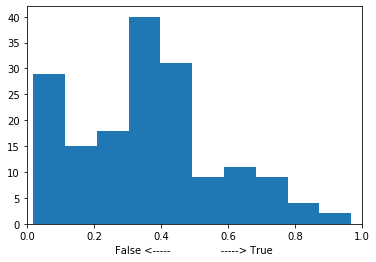

In [5]:
import matplotlib.pyplot as plt

print('Accuracy: ', clf.score(X[ind_test:],y[ind_test:]))
# print(clf.predict(X))
# print(clf.predict_proba(X)[:,1])
# print(y)
plt.hist(clf.predict_proba(X)[:,1])
plt.xlabel('False <-----                -----> True')
plt.xlim([0, 1])
plt.show()

In [6]:
d = dict(zip(dataset.features_, clf.coef_.tolist()[0]))
d_filter = filter(lambda x: x[1] != 0, d.items())
sorted(d_filter, key=lambda x: abs(x[1]))[::-1]

[('_S_art.n.01_woman.n.01_', 1.3202551020799698),
 ('_P_back.n.01_back.n.01_', 0.8651919722315243),
 ('chart.n.01', -0.8595115985874148),
 ('_S_chart.n.01_chart.n.01_', 0.791275465887096),
 ('_S_art.n.01_art.n.01_', 0.6793111985962742),
 ('_P_stand.v.01_stand.v.01_', 0.6452050823909851),
 ('_S_object.n.01_woman.n.01_', -0.6260269484847111),
 ('_P_sit.v.01_sit.v.01_', 0.4802178830737528),
 ('stand.v.01', -0.45469933499800347),
 ('_S_chart.n.01_icon.n.01_', 0.4370358883681366),
 ('_P_enjoyment.n.02_woman.n.01_', 0.31067535131261936),
 ('_Decoration_', -0.30605236774055855),
 ('_S_nature.n.03_rock.n.01_', 0.29474780639501075),
 ('_S_city.n.01_city.n.01_', 0.24977515821435495),
 ('_P_stand.v.01_be.v.01_', -0.24918892514834753),
 ('_S_wall.n.01_window.n.01_', 0.23564653897772816),
 ('_Person_front_', 0.2238157240478356),
 ('bucket.n.01', -0.21701389765974885),
 ('_S_wall.n.01_hospital.n.01_', 0.20562824439570102),
 ('_S_furniture.n.01_sofa.n.01_', 0.1994414296773402),
 ('_S_nature.n.03_park

In [13]:
# todo - unseen keywords

In [7]:
A = ['a','b','c']
B = ['d','e']
[a+b for a in A for b in B]

['ad', 'ae', 'bd', 'be', 'cd', 'ce']